In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
df = pd.read_csv("train_test_data_v1.csv")
df

,Unnamed: 0,title_len,body_len,upvote_ratio,time,compound_score,num_early_comments,num_comments,num_top_comments,score
0,l8rf4k,22,0,0.98,600.0,0.0000,623,12483,68.0,413085.0
1,l6wu59,38,0,0.97,340.0,0.4019,350,12840,80.0,315560.0
2,l78uct,29,0,0.97,786.0,0.2732,1332,23681,111.0,280976.0
3,l846a1,36,0,0.97,784.0,0.2732,1128,20563,106.0,252031.0
4,l6x130,291,183,0.97,349.0,-0.5267,141,18325,69.0,222152.0
...,...,...,...,...,...,...,...,...,...,...
136,nfa216,37,5270,0.77,298.0,0.9942,16,573,203.0,633.0
137,nfbwv5,68,875,0.79,379.0,0.9517,7,130,49.0,456.0
138,nfjo84,52,0,0.80,684.0,0.0000,2,41,10.0,175.0
139,nfkn43,73,0,0.85,722.0,-0.4215,11,99,35.0,137.0


We make an outputs dataframe, and set a "principal" score, which is the principal axis from the PCA on these 3 features.

In [128]:
outputs = df[['score', 'num_comments', 'upvote_ratio']].astype(float)

In [136]:
outputs["norm_score"] = (outputs.score - outputs.score.mean()) / outputs.score.std()
outputs["norm_comments"] = (outputs.num_comments - outputs.num_comments.mean()) / outputs.num_comments.std()
outputs["norm_ratio"] = (outputs.upvote_ratio - outputs.upvote_ratio.mean()) / outputs.upvote_ratio.std()


outputs_final = outputs[['norm_score', 'norm_comments', 'norm_ratio']]
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(outputs_final)
pca.components_[0]

array([0.6594436 , 0.59671171, 0.45724093])

In [137]:
outputs["principal"] = pca.components_[0][0] + pca.components_[0][1]*outputs.norm_comments + pca.components_[0][2]*outputs.norm_ratio 

In [141]:
df["principal"] = outputs.principal

We shrink the time values because they give my computer a headache.

In [143]:
## df['small_times'] = df.time_created/1000000

## plt.hist(df['score'])

We regress against time, because we don't want to be biased towards older posts.

In [146]:
## from sklearn.linear_model import LinearRegression

## slr = LinearRegression(copy_X = True)

## slr.fit(df['small_times'].values.reshape(-1,1), df['principal'].values)

Our final output variable is called popularity_score.

In [147]:
##b0 = slr.intercept_
## b1 = slr.coef_[0]

## df['popularity_score'] = df.principal - b0 - b1 * df.small_times
df['class'] = (df['principal'] > 1)


In [148]:
## code from K Nearest Neighbors Lecture, accuracy
def get_acc(model,X,y):
    pred = model.predict(X)
    return np.sum(pred == y)/len(y)


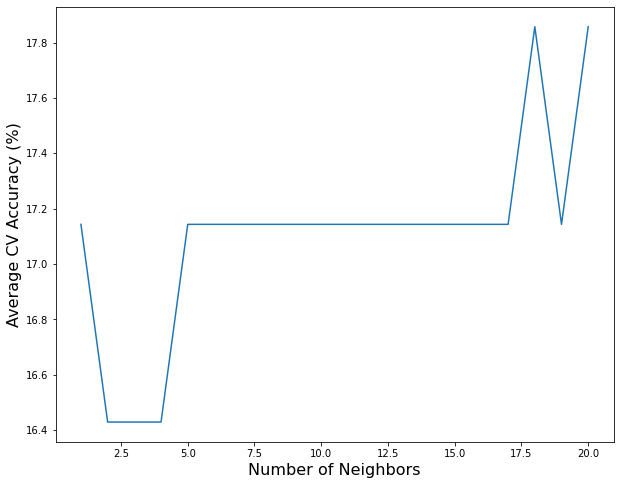

In [166]:
## code from K Nearest Neighbors Lecture
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
## define data

kfold = StratifiedKFold(5,shuffle = True,random_state = 440)

max_neighbors = 20

X = df[['title_len','num_early_comments']].to_numpy()
y = df[['class']].to_numpy()


## Make an empty array to hold your cv accuracies here
accuracy = np.zeros((5,max_neighbors))

for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = 0;
    j = 0
    for i in range (0,max_neighbors):
        knn = KNeighborsClassifier(n_neighbors = i+1)
        knn.fit(X_train,y_train.ravel())
        accuracy[j][i] = get_acc(knn,X_test,y_test.ravel())
        i = i+1
    j = j+1

#Plot how the accuracy changes

plt.figure(figsize=(10,8))

## Plot the number of neighbors on the x
## plot the avg cross validation accuracy on the y
plt.plot(np.linspace(1,max_neighbors,num=max_neighbors),100*np.mean(accuracy,axis=0))

## Use these as your axes labels
plt.xlabel("Number of Neighbors", fontsize=16)
plt.ylabel("Average CV Accuracy (%)", fontsize=16)

plt.show()